# Competitive Evaluation

## Setup

In [144]:
%matplotlib notebook

import itertools
import logging
from functools import partial

import gensim
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import numpy as np
import pandas as pnd
import os
from sklearn.cluster import *
from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.manifold import TSNE
from sklearn import svm, metrics

from knub.thesis.util import *

## Topic Coherence

* **Number of topics:** $K = 50$ for both *20news* and *nips*

**Approach**:
1. TM Corpus: lowercasing, tokenization, stopwords removal
2. WE Corpus: Wikipedia corpus trained with 50, 100, 200 dimensions
3. Restrict TM corpus to words which occur in WE model
4. Train different competitors
5. Evaluate TC using Palmetto tool from *Exploring the Space of Topic Coherence Measures* using the $C_V$ topic coherence measure


In [318]:
def load_topic_coherence(f):
    return pnd.read_csv("/home/stefan.bunk/master-thesis/results/topic-coherence/" + f, sep="\t", header=None)
    

def plot_iteration_for(df_param, params, r=0.9):
    matplotlib.style.use('classic')
    plt.figure()
    colors = iter(["green", "red", "blue", "yellow"] + plt_colors.cnames.keys())
    for model, df_group in df_param.groupby(params):
        plt.plot(df_group["iteration"], df_group["TC"] * 100, color='white',
                 label=model, marker='o', markerfacecolor=next(colors), markersize=12)

    plt.xlabel("Iteration")
    plt.ylabel("Topic Coherence")
    
    min_TC = df_param["TC"].min() * 100
    max_TC = df_param["TC"].max() * 100
    diff_TC = max_TC - min_TC
    lower_TC = min_TC - r * diff_TC
    upper_TC = max_TC + r * diff_TC
    plt.ylim((lower_TC, upper_TC))
    
    plt.xlim((df_param["iteration"].min() - 20, df_param["iteration"].max() + 20))

    plt.legend(loc="best")

### Base LDA

In [369]:
df_tc_lda = pnd.DataFrame.from_records([
    ("20news", "", "iterations=1500", 0.422, 0.078),
    ("nips", "", "iterations=1500", 0.408, 0.054)
], columns=["dataset", "params", "notes", "TC", "TC_std"])
df_tc_lda

,dataset,params,notes,TC,TC_std
0,20news,,iterations=1500,0.422,0.078
1,nips,,iterations=1500,0.408,0.054


**TODO**: Add new results from alpha-beta search
Also do some for nips

### LFTM

LFTM does not sample only from the multinomial topic-word distribution as LDA, but also in the embedding space by defining a word distribution for a given topic based on the similarity of words with the topic vector.
From which distribution to sample from is governed by the $\lambda$ parameter.

* $\alpha$, $\beta$: same as standard LDA
* $\lambda$: mixing factor between multinomial LDA and word embedding probability distribution. $\lambda = 0.6$ was reported to achieve highest topic coherence

In [311]:
df_tc_lflda = load_topic_coherence("lflda.txt")
df_tc_lflda.columns = ["embedding-dimension", "lambda", "alpha", "beta", "iteration", "TC", "TC_std"]
df_tc_lflda

,embedding-dimension,lambda,alpha,beta,iteration,TC,TC_std
0,200,0.6,0.02,0.02,50,0.442,0.091
1,200,0.6,0.02,0.02,100,0.436,0.092
2,200,0.6,0.02,0.02,150,0.445,0.091
3,200,0.6,0.02,0.02,200,0.441,0.086
4,200,0.6,0.02,0.02,250,0.437,0.084
5,200,0.6,0.02,0.02,300,0.441,0.092
6,200,0.6,0.02,0.02,350,0.435,0.089
7,200,0.6,0.02,0.02,400,0.439,0.085


<IPython.core.display.Javascript object>


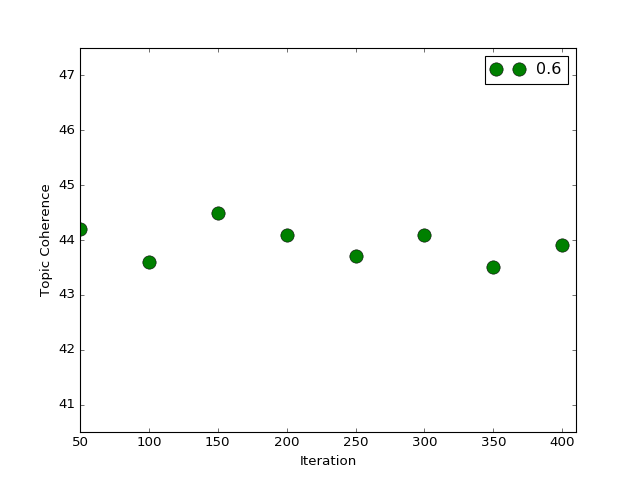

In [312]:
plot_iteration_for(df_tc_lflda, ["lambda"], r=3)

**Results**:
LFTM achieves improvements of $~ 1.8$ in TC.
Training time is very slow (see below).

**TODO**:
* As reported in the paper, we ran 1500 iterations of standard LDA, and then 500 iterations of LFTM. However, the big step in TC seems to occur in the first 50 iterations, need to rerun experiments in this range.
* In theory, LFTM should benefit from higher nr. of dimensions and should achieve lower results with less dimensions.

### TopicVec

TopicVec replaces the multinomial topic-word distribution from LDA and replaces with an WE-inspired word distribution based on the immediate context of a word. Topics are points in the embedding space.

**Parameters**:

* number of topic dimensions
* $\alpha$: same as LDA

In [326]:
df_tc_topicvec = load_topic_coherence("topicvec.txt")
df_tc_topicvec.columns = ["corpus", "embedding-dimension", "iteration", "TC", "TC_std"]
df_tc_topicvec = df_tc_topicvec.sort_values(["corpus", "embedding-dimension", "iteration"])
df_tc_topicvec.head()

,corpus,embedding-dimension,iteration,TC,TC_std
33,orig,50,100,0.426,0.085
35,orig,50,500,0.468,0.069
34,orig,100,100,0.414,0.070
36,orig,200,500,0.485,0.082
1,our,50,1,0.312,0.019


<IPython.core.display.Javascript object>


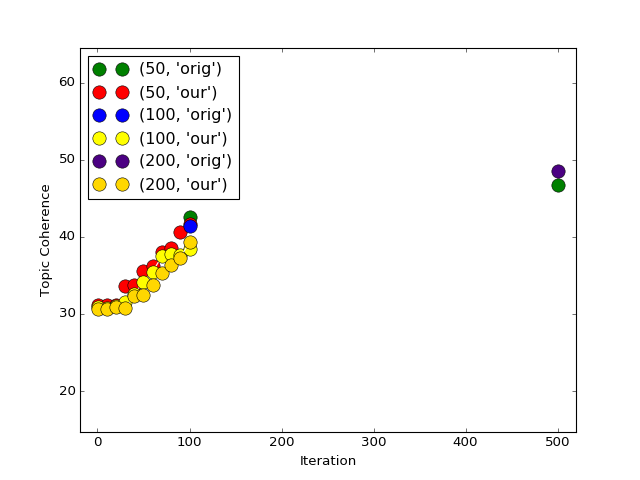

In [327]:
plot_iteration_for(df_tc_topicvec, ["embedding-dimension", "corpus"])

**Results**:
TopicVec achieves the highest topic coherence with 46.8.
Higher dimensions converge slower, but seem to end with higher TC.

**TODO**:
* TopicVec achieves higher results with the original data set, which does not lowercase, does not remove stop words.
* Need to explore the space between 100-500 iterations

In [325]:
df_tc_topicvec_topics = pnd.read_csv("/home/stefan.bunk/topicvec/results/corpus-orig.dim-50.iterations-500/topics", sep=" ", header=None)
df_tc_topicvec_topics.columns = ["topic-id", "probability"] + list(range(1, 11))
df_tc_topicvec_topics

,topic-id,probability,1,2,3,4,5,6,7,8,9,10
0,25,0.068338,god,faith,moral,morality,truth,christians,religion,atheists,belief,bible
1,23,0.056404,encryption,file,key,available,use,information,files,software,server,data
2,38,0.049740,output,scsi,file,jpeg,printf,image,window,null,stream,memory
3,49,0.048265,armenians,armenian,turkish,armenia,israel,soldiers,azerbaijan,turks,villages,lebanese
4,48,0.047695,card,drive,disk,drives,sale,floppy,windows,video,controller,price
5,46,0.046646,writes,says,mamma,jesus,know,went,told,apartment,come,father
6,4,0.046221,engine,car,windows,speed,brake,use,wiring,drive,cars,like
7,30,0.040092,team,hockey,players,season,game,nhl,league,teams,games,play
8,42,0.039293,pts,period,game,pit,puck,flyers,detroit,scorer,boston,philadelphia
9,47,0.038447,government,law,court,amendment,rights,state,constitution,right,laws,militia


### Gaussian LDA

Learning works better with **lower number of dimensions** (50 instead of 200).
Results are better, but still not good

> Yes, I have a feeling, I ran the experiments on 50 dimensional vectors.
> I am a little sad that it does not work for higher dimensional embeddings, but clearly there is something interesting going on which might give some insights about the structure of the space. Can you point me to the topics for D = {50, 200}.


Topics are better, but still not good. Previously, the topics were **almost uniform**.

Now, actual topics emerge but there are still a lot of noise topics. **Pre-initializing the topic vectors** to the **mean** of standard LDA's topics did not help

**Parameters:**
* $\alpha$: as in standard LDA
* number of dimensions

In [123]:
pnd.read_csv("/home/stefan.bunk/Gaussian_LDA/results/dim-50.alpha-0-02.output/090.topics", sep=" ", header=None)

,0,1,2,3,4,5,6,7,8,9
0,squarewave,quickdraw,reradiated,power-assist,push-pin,guard-rails,degauss,lightmeter,air-filter,encryptor
1,strong-hold,s.q,vatican,salyuts,a.s.s,offroading,stillwater,jcfs,rts,fusebox
2,s.q,f.a.q,o.h.o,wetbike,lernu,strong-hold,wob,a.i.d.s,c.r,xtian
3,three,two,good,many,new,first,four,second,several,last
4,people,government,world,group,israel,jews,national,germany,turkish,israeli
5,state,s.q,strong-hold,wiley,u.u,bill,stang,nelly,cayman,apple
6,buy,purchase,sell,buying,bought,purchasing,sale,sold,out-of-staters,pay
7,pre-judged,obviously,bullshitting,clearly,o.h.o,acknowledged,brought,effectively,s.q,even
8,f.a.q,wayner,a.s.s,s.q,hoffman,wetbike,slc,x-news,appelquist,xev
9,team,game,white,games,play,black,players,red,blue,win


In [197]:
df_tc_gaussian = load_topic_coherence("gaussian_lda.txt")
df_tc_gaussian.columns = ["iteration", "initialization-method", "embedding-dimension", "alpha", "TC", "TC_std"]
df_tc_gaussian = df_tc_gaussian.sort_values(["embedding-dimension", "initialization-method", "alpha", "iteration"])
df_tc_gaussian.head()

,iteration,initialization-method,embedding-dimension,alpha,TC,TC_std
43,0,mean,50,0.02,0.260,0.016
44,10,mean,50,0.02,0.347,0.084
45,20,mean,50,0.02,0.356,0.091
46,30,mean,50,0.02,0.360,0.090
47,40,mean,50,0.02,0.369,0.090


<IPython.core.display.Javascript object>


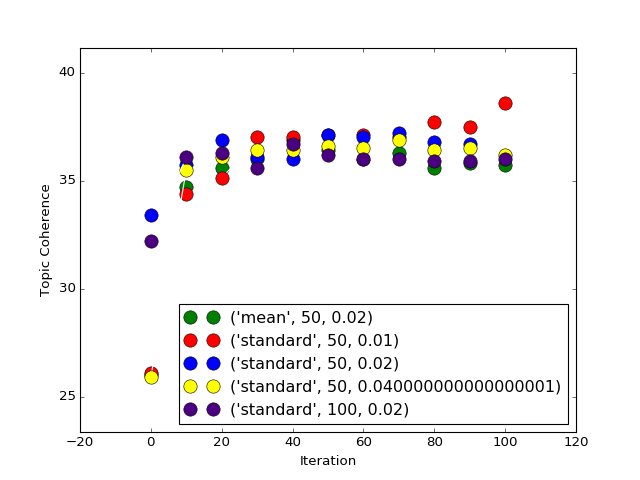

In [328]:
plot_iteration_for(df_tc_gaussian, ["initialization-method", "embedding-dimension", "alpha"], r=0.2)

**Iterations against likelihood**

<IPython.core.display.Javascript object>


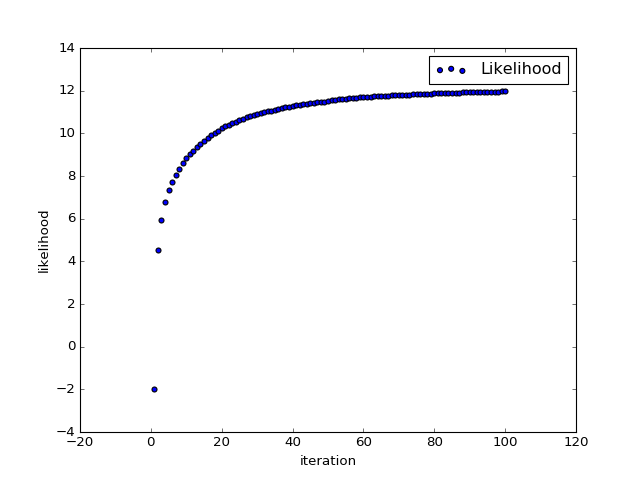

In [329]:
df_tc_gaussian_iterations = pnd.read_csv("/home/stefan.bunk/Gaussian_LDA/results/initialization-mean.dim-50.alpha-0-02.output/iterations.txt", sep="\t")
df_tc_gaussian_iterations.plot("iteration", "likelihood", kind="scatter", label="Likelihood")

**Time for each iteration**

<IPython.core.display.Javascript object>


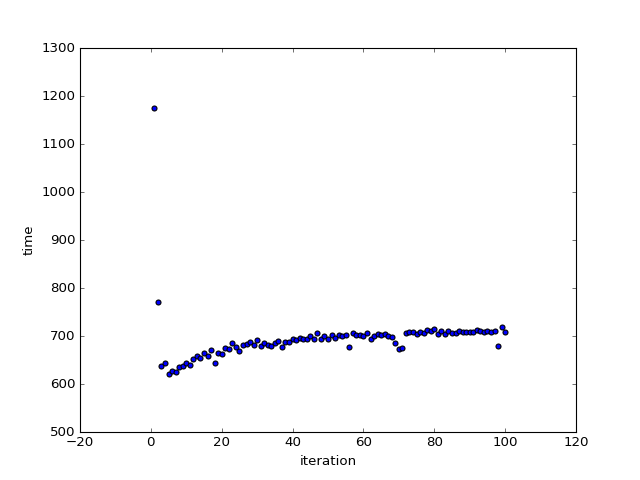

In [330]:
df_tc_gaussian_iterations.plot("iteration", "time", kind="scatter")

**Results:** Gaussian LDA achieves the lowest TC of all systems. Also, the model cannot handle higher dimensions.

**TODO:**
* Answer author, no further investigation until new insights
* Will test on NIPS

### sHDP

Similar to Gaussian LDA, but models a von Mises-Fisher distribution on the hypercube instead of a Gaussian distribution in the embedding space.

**Parameters**:
* $\kappa \in (0.5, 1]$, $\tau \in [0;)$: parameters for the learning rate of SGD
* $\gamma$: stick-breaking parameter 
* $\alpha$: concentration parameter for the Dirichlet process

So far no results with 20news. **Parameter search** did not help:

In [111]:
# kappa, tau in [(0.6, 0.8), (0.505, 0.8), (0.6, 0.1), (0.6, 10), (0.6, 100)]:
    # alpha in [0.5, 0.9, 1.0, 1.5, 10]:
        # gamma in [0.5, 1.0, 1.5, 10]:
            # run_shdp()

<IPython.core.display.Javascript object>


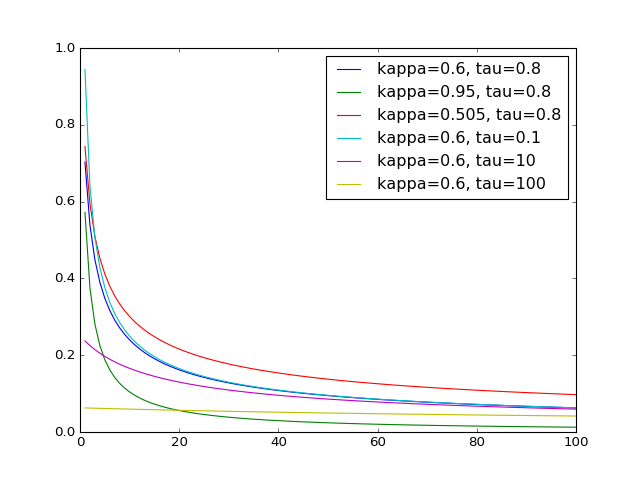

In [339]:
x = np.arange(1, 101)
plt.figure()
for kappa, tau in [(0.6, 0.8), (0.95, 0.8), (0.505, 0.8), (0.6, 0.1), (0.6, 10), (0.6, 100)]:
    y = (x + tau)**(-kappa)
    plt.plot(x, y, label="kappa=" + str(kappa) + ", tau=" + str(tau))

plt.legend()

In [352]:
df_tc_shdp_nips = load_topic_coherence("shdp_nips.txt")
df_tc_shdp_nips.columns = ["embeddings", "dimensions", "seed", "topics", "alpha", "gamma",
                           "kappa", "tau", "step-size", "TC", "TC_std"]
df_tc_shdp_nips["iteration"] = 1
df_tc_shdp_nips

,embeddings,dimensions,seed,topics,alpha,gamma,kappa,tau,step-size,TC,TC_std,iteration
0,theirs,50,1,50,1.0,2.0,0.6,0.8,10,0.375,0.084,1
1,ours,50,1,50,1.0,2.0,0.6,0.8,10,0.362,0.058,1


<IPython.core.display.Javascript object>


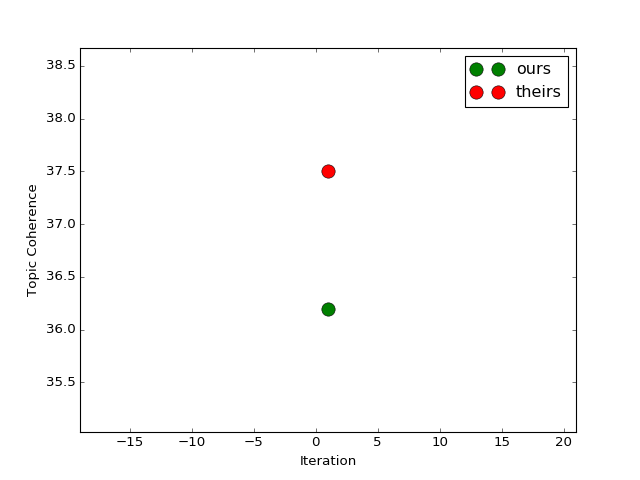

In [353]:
plot_iteration_for(df_tc_shdp_nips, ["embeddings"])

**NIPS**

In [343]:
df_tc_shdp_nips_topics = pnd.read_csv("/home/stefan.bunk/sHDP/results/20news/embeddings-ours.dim-50.seed-1.topics-50.alpha-1-0.gamma-2-0.kappa-0-6.tau-0-8.batch-10/prob-based.topics", header=None, sep=" ")
df_tc_shdp_nips_topics

,0,1,2,3,4,5,6,7,8,9
0,computation,solution,approximation,stochastic,entropy,errors,generalize,data,calculate,nonlinear
1,ten,training,list,probability,times,number,features,kaufmann,function,length
2,code,updates,applications,derived,parameter,mapping,inputs,output,data,methods
3,networks,centers,measure,shown,related,points,gaussian,weight,proceedings,show
4,activated,trained,unit,total,apply,layer,error,decrease,representation,operations
5,current,positions,networks,division,find,show,layer,form,effects,section
6,model,input,circuitry,neural,frequencies,left,analysis,found,press,abstract
7,partial,caused,change,resulting,lack,positive,set,increasing,stimulus,shown
8,version,presentation,information,shown,current,network,shows,space,show,research
9,consisting,report,means,local,dependent,splitting,processes,factor,information,achieve


**Results**:
Similarly to Gaussian LDA, learning a model/finding the right parameters is hard. The model also seems to have a problem with higher dimensions.

**TODO**:
* Ask author for regarding parameter settings for 20news

### WELDA

WELDA resamples the words in the text based on a Gaussian distribution over the topic space. The resample probability is $\lambda$.

* $\alpha$, $\beta$: standard LDA
* $\lambda$: resample probability

In [354]:
df_tc_welda = load_topic_coherence("gaussian_welda.txt")
df_tc_welda.columns = ["iteration", "distance-method", "lambda", "TC", "TC_std"]
df_tc_welda = df_tc_welda.sort_values(["distance-method", "lambda", "iteration"])
df_tc_welda

,iteration,distance-method,lambda,TC,TC_std
0,10,cos,0.5,0.443,0.078
4,20,cos,0.5,0.444,0.081
8,30,cos,0.5,0.446,0.077
12,40,cos,0.5,0.450,0.078
16,50,cos,0.5,0.451,0.078
20,60,cos,0.5,0.451,0.078
24,70,cos,0.5,0.452,0.078
28,80,cos,0.5,0.452,0.078
32,90,cos,0.5,0.452,0.078
36,100,cos,0.5,0.453,0.078


<IPython.core.display.Javascript object>


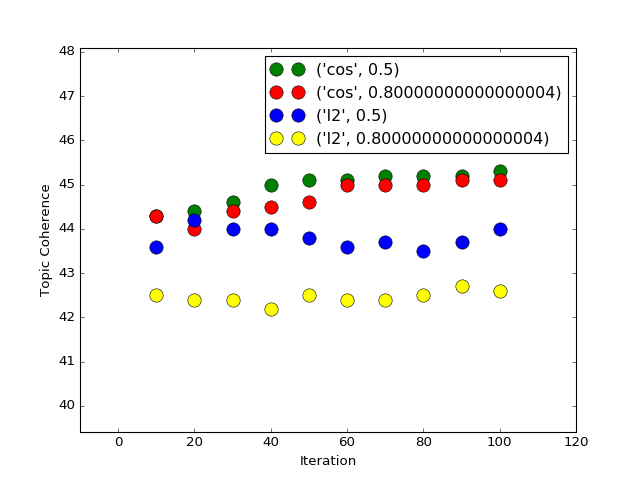

In [355]:
plot_iteration_for(df_tc_welda, ["distance-method", "lambda"])

**Results**:
WELDA increases the TC compared to standard LDA by $~ 2.8$. After topicvec, it is the second best model with regards to TC.

In [360]:
df_tc_nips_welda = load_topic_coherence("gaussian_welda_nips.txt")
df_tc_nips_welda.columns = ["iteration", "embedding-dimensions", "distance-method", "lambda", "TC", "TC_std"]
df_tc_nips_welda = df_tc_nips_welda[df_tc_nips_welda["iteration"] % 10 == 0]
df_tc_nips_welda.head()

,iteration,embedding-dimensions,distance-method,lambda,TC,TC_std
0,0,200,cos,0.5,0.409,0.055
5,10,200,cos,0.5,0.406,0.063
10,20,200,cos,0.5,0.412,0.065
15,30,200,cos,0.5,0.411,0.067
20,40,200,cos,0.5,0.415,0.069


**NIPS**:

<IPython.core.display.Javascript object>


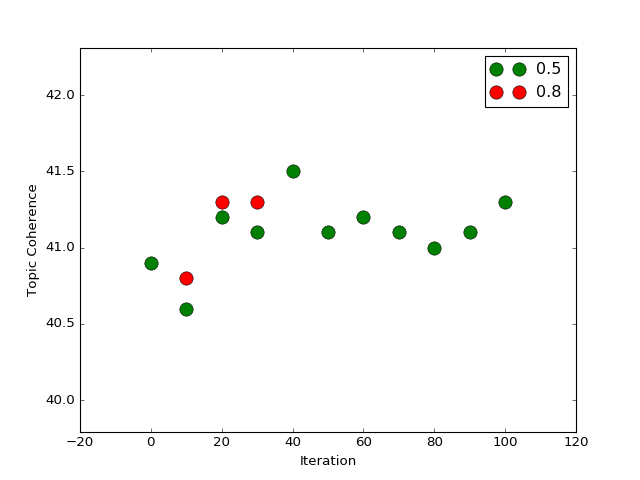

In [361]:
plot_iteration_for(df_tc_nips_welda, ["lambda"])

**Results:**:
Again WELDA increases the TC by $0.4$

## Runtimes

**For 20news corpus:**

In [347]:
pnd.set_option("display.max_colwidth", 100)
df_runtimes = pnd.DataFrame.from_records([
    ("LDA", "iterations=1500, threads=4", "8min"),
    ("LFLDA", "iterations=400, embedding-dimension=200, lambda=0.6, threads=5", "23h 30min"),
    ("Gaussian LDA", "iterations=100, embedding-dimension=50, threads=2", "19h 40min"),
    ("topicvec", "iterations=100, embedding-dimension=100, threads=4", "45min"),
    ("topicvec", "iterations=100, embedding-dimension=200, threads=4", "53min"),
    ("sHDP on NIPS!", "kappa=0.8, tau=0.6", "20 min"),
    ("WELDA", "iterations=100, lambda=0.5, threads=4", "4 h"),
], columns=["method", "notes", "runtime"])
df_runtimes

,method,notes,runtime
0,LDA,"iterations=1500, threads=4",8min
1,LFLDA,"iterations=400, embedding-dimension=200, lambda=0.6, threads=5",23h 30min
2,Gaussian LDA,"iterations=100, embedding-dimension=50, threads=2",19h 40min
3,topicvec,"iterations=100, embedding-dimension=100, threads=4",45min
4,topicvec,"iterations=100, embedding-dimension=200, threads=4",53min
5,sHDP on NIPS!,"kappa=0.8, tau=0.6",20 min
6,WELDA,"iterations=100, lambda=0.5, threads=4",4 h


## Document classification

In [364]:
def evaluate_document_classification(df_param):
    nr_classes = len(set(df_param["class"].tolist()))
    nr_features = df_param.columns[-1]
    
    feature_columns = list(range(1, nr_features + 1))
    X = df_param.as_matrix(feature_columns)
   
    train, test = train_test_split(df_param, test_size = 0.2)
    X_train = train.as_matrix(range(1, nr_features + 1))
    #X_train = normalize(X_train, norm="l1")
    X_test = test.as_matrix(range(1, nr_features + 1))
    print X_train.shape
    print X_test.shape
    
    model = svm.LinearSVC(penalty='l1', dual=False)
    y_train = train["class"].tolist()
    model.fit(X_train, y_train)
    
    y_test = test["class"].tolist()
    y_predictions = model.predict(X_test)
    print metrics.classification_report(y_test, y_predictions, digits=3)
    
    
#    for clazz in range(2):
#        model = svm.LinearSVC(penalty='l1', dual=False)
#        #y_train = train["class"].tolist()
#        # y_train = (train["class"] == clazz).apply(int)
#        ##y_test = test["class"].tolist()
#        y_test = (test["class"] == clazz).apply(int)
#        model.fit(X_train, y_train)
#        y_predictions = model.predict(X_test)
#        print metrics.classification_report(y_test, y_predictions, digits=3)

### LDA

In [365]:
df_dc_lda = pnd.read_csv("/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.with-classes/model.document-topics",
                        sep=" ", header=None)
df_dc_lda.columns = range(1, 51)

df_dc_lda.insert(0, "class", pnd.read_csv("/home/stefan.bunk/master-thesis/data/20newsgroups/20news-bydate-train-with-classes/articles.class.txt",
                                 header=None))
evaluate_document_classification(df_dc_lda)

(9051, 50)
(2263, 50)
             precision    recall  f1-score   support

          0      0.062     0.102     0.077       108
          1      0.047     0.063     0.054       111
          2      0.125     0.011     0.020        94
          3      0.200     0.008     0.015       129
          4      0.054     0.073     0.062       110
          5      0.000     0.000     0.000        66
          6      0.052     0.102     0.068       118
          7      0.030     0.029     0.030       103
          8      0.059     0.119     0.079       118
          9      0.072     0.079     0.076       139
         10      0.038     0.064     0.048       109
         11      0.024     0.024     0.024       123
         12      0.091     0.049     0.063       123
         13      0.049     0.044     0.046       114
         14      0.087     0.059     0.070       119
         15      0.148     0.028     0.048       141
         16      0.028     0.036     0.031       111
         17      0.068 

### TopicVec

**Infers topics for each category**

In [366]:
TOPICVEC_RESULTS_FOLDER = "/home/stefan.bunk/topicvec/old_results"
document_topics_files = [TOPICVEC_RESULTS_FOLDER + "/" + d + "/document-topics" for d
                         in os.listdir(TOPICVEC_RESULTS_FOLDER)]
document_topics_files = [f for f in document_topics_files if os.path.exists(f)]
f = document_topics_files[0]
print f
df = pnd.read_csv(f, sep="\t", header=None)
df.columns = ["class", "file"] + range(1, 51)
#del df['file']
evaluate_document_classification(df)
#df.head()

/home/stefan.bunk/topicvec/old_results/dim-100.iterations-90/document-topics
(9036, 50)
(2259, 50)
             precision    recall  f1-score   support

          0      0.367     0.196     0.256       112
          1      0.585     0.783     0.669       106
          2      0.478     0.232     0.312        95
          3      0.275     0.393     0.324       112
          4      0.383     0.338     0.359       130
          5      0.500     0.026     0.049        77
          6      0.380     0.516     0.438       122
          7      0.539     0.414     0.468       133
          8      0.220     0.194     0.206       124
          9      0.593     0.696     0.640       115
         10      0.444     0.370     0.404       119
         11      0.370     0.309     0.337       110
         12      0.457     0.731     0.562       108
         13      0.388     0.570     0.462       128
         14      0.500     0.588     0.541       119
         15      0.579     0.712     0.639       118

In [367]:
#df_doc_class = pnd.read_csv("/home/stefan.bunk/topicvec/results/corpus-orig.dim-50.iterations-100/corpus-orig.dim-50.iterations-100foooo-100.topic.prop", sep="\t", header=None)
df_doc_class = pnd.read_csv("/home/stefan.bunk/topicvec/results/corpus-orig.dim-50.iterations-100/corpus-orig.dim-50.iterations-100foooo-100.topic.prop", sep="\t", header=None)
df_doc_class.columns = ["class", "file"] + range(1, 51)
del df_doc_class["file"]
evaluate_document_classification(df_doc_class)

(9025, 50)
(2257, 50)
             precision    recall  f1-score   support

          0      0.410     0.150     0.219       107
          1      0.189     0.153     0.169       111
          2      0.216     0.065     0.099       124
          3      0.302     0.217     0.252       120
          4      0.375     0.089     0.144       101
          5      0.322     0.310     0.316       126
          6      0.267     0.528     0.354       127
          7      0.363     0.381     0.372       118
          8      0.311     0.339     0.325       112
          9      0.322     0.491     0.389       114
         10      0.416     0.622     0.498       111
         11      0.424     0.538     0.475       104
         12      0.338     0.179     0.234       123
         13      0.447     0.663     0.534       101
         14      0.520     0.413     0.460       126
         15      0.302     0.664     0.415       110
         16      0.410     0.342     0.373       120
         17      0.614 

## TODO

* Google embeddings

## Notes

* Proper experiments are hard
* How to ensure same preprocessing for all methods? Is this desired?